# Práctica Sistemas de Recomendación

**Francisco Javier Tébar Martínez**

29/04/2019

# Ejercicio 1

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS
from sklearn.metrics.pairwise import cosine_similarity, manhattan_distances, euclidean_distances, pairwise_kernels

### Preparación de los datos

Cargamos los datos en formato json. 

In [2]:
keywords_df = pd.read_json('datos/imdb_example_keywords.json')

In [3]:
keywords_df.head()

,idImdb,keywords,titulo
0,tt0006864,"[multiple storyline, babylon babylonia, paris ...",Intolerancia (1916)
1,tt0010323,"[somnambulist, expressionism, hypnosis, avant ...",El gabinete del Dr. Caligari (1920)
2,tt0012349,"[lucifer morningstar character, the little tra...",El chico (1921)
3,tt0012364,"[ghost story, ghost, salvation, alcoholic, tub...",La carreta fantasma (1921)
4,tt0013442,"[vampire, self sacrifice, bite mark, dracula, ...",Nosferatu (1922)


In [4]:
len(keywords_df)

1502

Tenemos 1502 documentos

Separamos las palabras individualmente.

In [5]:
keywords_df_unnested = [' '.join(keywords_df.keywords[i]) for i in range(len(keywords_df))]

In [6]:
keywords_df["keywords_new"] = keywords_df_unnested

Podemos ver las palabras que aparecen con más frecuencia graficamente con la función ``WordCloud``.

In [7]:
text = []
for element in keywords_df.keywords:
    text = text + element
text = ' '.join(text)

In [8]:
wordcloud = WordCloud(

    stopwords=STOPWORDS,
    height=2000,
    width=4000

).generate(text)

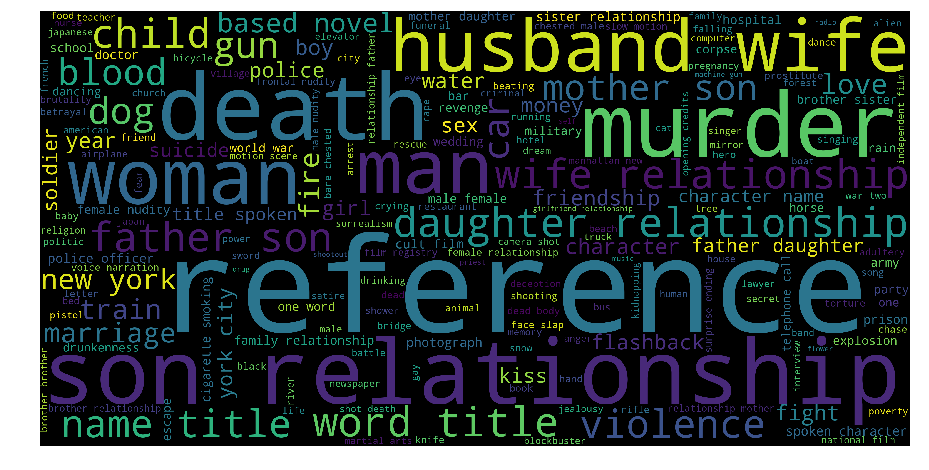

In [9]:
plt.figure(figsize=(16,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### Tf-idf

Para crear el sistema de recomendación basado en el contenido utilizarémos el método Tf-idf que determina la importancia de un término (palabra o conjunto de palabras) en un documento dentro del contexto de un confunto de documentos. Matemáticamente se puede expresar como:

$$ tf-idf_{i,j} = tf_{i,j} \bullet log(\frac{N}{df_i})$$

Con:
<li>$tf_{i,j}$ : el número total de aparaciones de i en j (frecuencia del término).
<li>$df_i$ : el número total de documentos en los que aparece i.
<li>$N$ : el número total de documentos. 
    
Para ello podemos utilizar la función ``TfidfVectorizer`` de ``sklearn``. Esta tiene los siguientes parámetros principales:

<li> ``analyzer`` : Determina el formato de las variables a utilizar. En concreto en nuestro caso utlizaremos palabras. 
<li> ``stop_words`` : Elimina palabras que no son útiles para la recomendación, como son por ejemplo *and*, *the*, *him*...
<li> ``min_df`` : Determina el mínimo número de veces que un término debe aparecer para considerarse. 
<li> ``max_df`` : Determina el máximo número de veces que un término puede aparecer antes de descartarse.
<li> ``ngram_range`` : Se utiliza para indicar el número de combinaciones de palabras a tener en cuentas. Es decir, si utilizamos ngram_range = (1,3), considerará las palabras individuales, pares de palabras y trios de estas. Así, se tendrá en cuenta cualquiera de estas combinaciones si se repite un mínimo de veces (min_df). 

Implementamos el método con los parámetros que se muestran en la función ``TfidfVectorizer``.

In [10]:
tf_2 = TfidfVectorizer(

    analyzer='word',
    stop_words = "english",
    min_df=20,
    max_df = 500, # Sí aparece en 1 de cada 3 películas no será muy útil
    ngram_range =(1,3)

).fit(keywords_df.keywords_new)

In [11]:
tfidf_matrix = tf_2.transform(keywords_df.keywords_new)

In [12]:
tfidf_matrix.shape

(1502, 2304)

Vemos que en total tenemos 2304 términos con los parámetros considerados. 

Miremos algunos términos. 

In [22]:
term_df = pd.DataFrame(list(tf_2.vocabulary_.keys()))
term_df.columns = ["Term"]
term_df[0:10]

,Term
0,multiple
1,paris
2,france
3,time
4,national
5,film
6,registry
7,deception
8,intolerance
9,wedding


Para ver la similitud entre los términos para recomendar las películas necesitamos utilizar una distancia. En concreto probaremos las siguientes:
    
<li> Coseno similarity
<li> Euclidean distance
<li> Manhattan distance
<li> Pairwise kernels : En concreto en este caso utilizaremos un kernel gaussiano (*rbf*)

Implementamos las distancias. 

In [14]:
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
kernel_pairw = pairwise_kernels(tfidf_matrix, tfidf_matrix, metric = "rbf")
eucl_dist = euclidean_distances(tfidf_matrix, tfidf_matrix)
manh_dist = manhattan_distances(tfidf_matrix, tfidf_matrix)

titles = keywords_df.titulo
indices = pd.Series(keywords_df.index, index=keywords_df.titulo)

Creamos la función de recomendación. 

In [15]:
def recommendations(title, choose = "cosine similarity"):
    idx = indices[title]
    if choose == "cosine similarity":
        sim_scores = list(enumerate(cosine_sim[idx]))
    elif choose == "gaussian kernel":
        sim_scores = list(enumerate(kernel_pairw[idx]))
    elif choose == "euclidean distance":
        sim_scores = list(enumerate(eucl_dist[idx]))
    elif choose == "manhattan distance":
        sim_scores = list(enumerate(manh_dist[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:21]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

Miremos como funciona nuestro sistema de recomendación en función de las distancias. Iremos de la peor distancia a la mejor.

#### Distancia euclidea

Miremos una película bastante fácil de clasificar como es : Vengadores: Infinity War (2018).

In [16]:
recommendations('Vengadores: Infinity War (2018)', 'euclidean distance').head(20)

71                       Ahí está el detalle (1940)
216                   Jazz on a Summer's Day (1959)
251                               Teen Kanya (1961)
253                         Una vida difícil (1961)
343                                Sami swoi (1967)
421                            Ashani Sanket (1973)
576                          Lyubov i golubi (1985)
647                            Rojo amanecer (1989)
649                    Uçurtmayi Vurmasinlar (1989)
762                       Ostrov Sokrovishch (1989)
773                   Operatiunea 'Monstrul' (1976)
782                Cabra Marcado Para Morrer (1984)
804                  Kako je propao rokenrol (1989)
822                        Mi viaje a Italia (1999)
871                              Ard al-Khof (1999)
902                      Köyden Indim Sehire (1974)
904                         Saban Oglu Saban (1977)
908                           Çöpçüler Krali (1977)
939    Stanley Kubrick: Una vida en imágenes (2001)
945         

La distancia euclidea no funciona y prácticamente no conozco ni una sola película de las recomendadas. 

#### Distancia manhattan

In [17]:
recommendations('Vengadores: Infinity War (2018)', 'manhattan distance').head(20)

974                         Dzien swira (2002)
1105                         Persépolis (2007)
168                La noche del cazador (1955)
275                          Fellini 8½ (1963)
982                   La mejor juventud (2003)
1303             El gran hotel Budapest (2014)
252                           Viridiana (1961)
140                               Vivir (1952)
65            Lo que el viento se llevó (1939)
154                        Los inútiles (1953)
680                           Tito i ja (1992)
124     El diario de un cura de campaña (1951)
301                            Soy Cuba (1964)
402                  La última película (1971)
1379                              Mommy (2014)
967                            Big Fish (2003)
398                 La naranja mecánica (1971)
1042                         C.R.A.Z.Y. (2005)
111            Carta de una desconocida (1948)
78                       Ciudadano Kane (1941)
Name: titulo, dtype: object

Las películas en este caso no tienen nada que ver con la temática de Infinity War pero por lo menos son películas más conocidas y por tanto considero que lo hace ligeramente mejor a la distancia euclidea. 

#### Kernel gaussiano

In [18]:
recommendations('Vengadores: Infinity War (2018)', 'gaussian kernel').head(20)

1114                                Los Vengadores (2012)
1271                      Guardianes de la galaxia (2014)
1102                                     Star Trek (2009)
1328    Star Wars: Episodio VII - El despertar de la F...
595                             Aliens: El regreso (1986)
499                      Alien, el octavo pasajero (1979)
565                            El retorno del Jedi (1983)
17                       De la cocina al escenario (1925)
1051                                 Death in Gaza (2004)
1124                     Pries parskrendant i zeme (2005)
1208                             Kattradhu Thamizh (2007)
1242                                         Super (2010)
1299                  Final Cut: Hölgyeim és uraim (2012)
1321                                   Balak Palak (2012)
1414                                        Sachin (2017)
1483                   Kiborgy. Heroyi ne vmyrayut (2017)
1501                           Ananthu V/S Nusrath (2018)
521           

En este caso las recomendaciones son mucho mejores. Como sería de esperar la primera película recomendada tendría que estar relacionada con la saga de Avengers. Con relación al resto, al menos las 4 o 5 primeras recomendaciones pueden ser razonables, pero posteriormente las recomendaciones van perdiendo calidad rapidamente. 

#### Distancia coseno

In [19]:
recommendations('Vengadores: Infinity War (2018)', 'cosine similarity').head(20)

1114                                Los Vengadores (2012)
1271                      Guardianes de la galaxia (2014)
1102                                     Star Trek (2009)
1328    Star Wars: Episodio VII - El despertar de la F...
595                             Aliens: El regreso (1986)
499                      Alien, el octavo pasajero (1979)
565                            El retorno del Jedi (1983)
521                         El imperio contraataca (1980)
490                      La guerra de las galaxias (1977)
1203                                      Deadpool (2016)
553              La cosa (El enigma de otro mundo) (1982)
1197                Mad Max: Furia en la carretera (2015)
1260                 X-Men: Días del futuro pasado (2014)
348                   2001: Una odisea del espacio (1968)
1191        El caballero oscuro: La leyenda renace (2012)
1365                                         Logan (2017)
1081                           El caballero oscuro (2008)
1107          

Con la distancia coseno las recomendaciones son las mejores con diferencia (por lo menos conozco las 20 películas recomendadas). En general todas las recomendaciones son razonables y muchas de ellas siguen temáticas parecidas. 

Miremos alguna recomendación más con esta distancia. 

In [20]:
recommendations('El caballero oscuro (2008)', 'cosine similarity').head(20)

1191    El caballero oscuro: La leyenda renace (2012)
1007                             Batman Begins (2005)
1197            Mad Max: Furia en la carretera (2015)
1365                                     Logan (2017)
1300                                The Raid 2 (2014)
1203                                  Deadpool (2016)
1196                                    Origen (2010)
1048                               Infiltrados (2006)
623                          Jungla de cristal (1988)
668              Terminator 2: El juicio final (1991)
1065                    El ultimátum de Bourne (2007)
589                                     Brazil (1985)
584                                 Terminator (1984)
652                        Uno de los nuestros (1990)
1061                             V de Vendetta (2005)
120                               Al rojo vivo (1949)
719                         Ghost in the Shell (1995)
568                        El precio del poder (1983)
1114                        

Bueno nuevamente en general creo que las recomendaciones son razonables. Y recomienda en primer lugar la saga de Batman. 

Veamos alguna película más complicada que no pertenezca a una saga o tenga directamente películas similares. 

In [21]:
recommendations('La milla verde (1999)', 'cosine similarity').head(20)

271              Matar a un ruiseñor (1962)
756               American History X (1998)
1155                  Shutter Island (2010)
1450                            13th (2016)
366          Hasta que llegó su hora (1968)
1169                     Gran Torino (2008)
706                  Cadena perpetua (1994)
652              Uno de los nuestros (1990)
1061                   V de Vendetta (2005)
534     Pixote, la ley del más débil (1981)
964                   Ciudad de Dios (2002)
726           Sospechosos habituales (1995)
972                     Mystic River (2003)
527                    El resplandor (1980)
1365                           Logan (2017)
1081             El caballero oscuro (2008)
168             La noche del cazador (1955)
687           En el nombre del padre (1993)
398              La naranja mecánica (1971)
1068              Diamante de sangre (2006)
Name: titulo, dtype: object

Como era de esperar en este caso se cuelan algunas películas que no tienen mucho que ver como Logan. Sin embargo, las recomendaciones son bastante buenas con otras como Cadena perpetua, Shutter Island o La naranja mecánica. 

Podemos concluir sin lugar a dudas que la mejor distancia para nuestro modelo es la distancia coseno. 